# Data Analysis

We're now going to look in more detail at how the SSDA903 data is used to calculate the numbers we need for the predictions. 

Let's first load some of the dependencies we need, as well as the sample data. This tool includes sample data, so we can use this 
for exploring. If you run this notebook yourself you can easily swap this for your own files.

In [1]:
import pandas as pd
import numpy as np
from cs_demand_model import Config, DemandModellingDataContainer, PopulationStats
from cs_demand_model_samples import V1

data = V1.datastore

header_files = [f for f in data.files if "header" in f.name or "episode" in f.name]
header_files.sort(key=lambda x: x.metadata.year)
header_files


[DataFile(name='2017/header.csv', metadata=Metadata(name='header.csv', size=33527, year=2017, table=None)),
 DataFile(name='2017/episodes.csv', metadata=Metadata(name='episodes.csv', size=103508, year=2017, table=None)),
 DataFile(name='2018/header.csv', metadata=Metadata(name='header.csv', size=23426, year=2018, table=None)),
 DataFile(name='2018/episodes.csv', metadata=Metadata(name='episodes.csv', size=69446, year=2018, table=None)),
 DataFile(name='2019/header.csv', metadata=Metadata(name='header.csv', size=14844, year=2019, table=None)),
 DataFile(name='2019/episodes.csv', metadata=Metadata(name='episodes.csv', size=46259, year=2019, table=None)),
 DataFile(name='2020/header.csv', metadata=Metadata(name='header.csv', size=9284, year=2020, table=None)),
 DataFile(name='2020/episodes.csv', metadata=Metadata(name='episodes.csv', size=28729, year=2020, table=None)),
 DataFile(name='2021/header.csv', metadata=Metadata(name='header.csv', size=5928, year=2021, table=None)),
 DataFile(nam

# Merging files into a single view

The [DataContainer](../cs_demand_model/datacontainer.py) holds the code that merges these files into a single coherent view. This is done by joining the headers and episodes for each year to create a wide view.

In [2]:
config = Config()
dc = DemandModellingDataContainer(data, config)

dc.combined_year(2021).head(5)

,CHILD,SEX,DOB,ETHNIC,UPN,MOTHER,MC_DOB,DECOM,RNE,LS,CIN,PLACE,PLACE_PROVIDER,DEC,REC,REASON_PLACE_CHANGE,HOME_POST,PL_POST,URN
0,225242,2,2005-11-27,AIND,E024501213825,NaN,NaN,2019-11-20,P,D1,N8,A6,PR1,2020-05-01,X1,OTHER,Q17 9PC,B17 3IJ,5235464
1,225242,2,2005-11-27,AIND,E024501213825,NaN,NaN,2020-05-01,P,D1,N8,U5,PR1,NaT,X1,CLOSE,E19 9NR,A5 1ZI,4903819
2,53693,1,2007-12-28,MWBA,E072016439902,NaN,NaN,2020-04-01,P,E1,N6,U4,PR1,2020-10-31,E11,NaN,V21 2KD,Z24 1NH,4359866
3,168196,1,2009-10-12,APKN,L066695746570,NaN,NaN,2018-08-18,P,V4,N5,U5,PR4,2020-11-22,E16,NaN,Q3 2OQ,V10 9MO,6910542
4,637234,2,2006-08-07,APKN,G014513081279,NaN,NaN,2020-01-28,B,V3,N7,U4,PR4,2020-12-17,X1,PLACE,Q6 5CQ,K9 6YZ,3186853


Each of these year views for the available years are then merged into single table. This will lead to duplicate episodes, so we sort the data by
CHILD, DECOM (episode start) and DEC (episode end). Ongoing episodes will have a NA for DEC, so we make sure we sort NAs first:

In [3]:
combined = pd.concat(
    [
        dc.combined_year(year)
        for year in range(dc.first_year, dc.last_year + 1)
    ]
)
print(f"{combined.shape[0]} records in total.")


# We first sort by child, decom and dec, and make sure NAs are first (for dropping duplicates)
combined.sort_values(
    ["CHILD", "DECOM", "DEC"], inplace=True, na_position="first"
)

# If a child has two episodes starting on the same day (usually if NA in one year and then done in next)
# keep the latest non-NA finish date
combined.drop_duplicates(["CHILD", "DECOM"], keep="last", inplace=True)
print(f"{combined.shape[0]} records remaining after removing episodes that start on the same date.")
combined.head()

3737 records in total.
2827 records remaining after removing episodes that start on the same date.


,CHILD,SEX,DOB,ETHNIC,UPN,MOTHER,MC_DOB,DECOM,RNE,LS,CIN,PLACE,PLACE_PROVIDER,DEC,REC,REASON_PLACE_CHANGE,HOME_POST,PL_POST,URN
69,91,2,1999-10-19,MOTH,W064737016429,NaN,NaN,2016-09-01,P,J2,N2,H5,PR4,2017-10-13,E8,NaN,W11 2QK,Y7 6AL,2141660
358,290,2,2000-11-13,MWBC,S077270991828,NaN,NaN,2016-11-19,T,D1,N5,U5,PR4,2018-10-01,X1,NaN,O10 4BF,X15 3NT,9727828
359,290,2,2000-11-13,MWBC,S077270991828,NaN,NaN,2018-10-01,L,J3,N5,U5,PR4,2018-11-08,E46,NaN,O10 4BF,X15 3NT,9727828
507,519,1,2002-03-26,AOTH,Z083151961630,NaN,NaN,2017-03-09,P,J2,N6,U4,PR1,2017-12-23,E4A,NaN,O6 1YB,Y26 2WY,3701521
508,519,1,2002-03-26,AOTH,Z083151961630,NaN,NaN,2017-09-14,S,D1,N8,U5,PR4,2018-02-19,X1,NaN,G23 4FG,C14 9EK,5289150


Finally we make sure the children have no overlapping episodes

In [4]:
# What is the start date of the next episode
decom_next = combined.groupby("CHILD")["DECOM"].shift(-1)

# Find open episodes or those where the start date is greater than the next start date
change_ix = combined["DEC"].isna() | combined["DEC"].gt(decom_next)

print(f"There are {change_ix[change_ix].shape[0]} overlapping episodes")

# Set the end date to the next start date for those overlapping episodes
combined.loc[change_ix, "DEC"] = decom_next[change_ix]

There are 126 overlapping episodes


# Calculating extra properties

Now that we have one combined wide view of the data, we can add extra properties that we need to model the transitions. We are looking for children that are in states that are a combination of age and placement category (placement categories are broader groupings of placement types). 



In [5]:
with_ages = dc._add_ages(combined.copy())
with_ages[['CHILD', 'DOB', 'DECOM', 'DEC', 'age', 'end_age']]

,CHILD,DOB,DECOM,DEC,age,end_age
69,91,1999-10-19,2016-09-01,2017-10-13,16.871098,17.985434
358,290,2000-11-13,2016-11-19,2018-10-01,16.016866,17.881393
359,290,2000-11-13,2018-10-01,2018-11-08,17.881393,17.985434
507,519,2002-03-26,2017-03-09,2017-09-14,14.954550,15.472018
508,519,2002-03-26,2017-09-14,2018-02-19,15.472018,15.904611
...,...,...,...,...,...,...
820,994520,1999-12-18,2015-10-24,2017-12-12,15.849852,17.985434
74,994928,2005-02-01,2017-01-11,2020-06-17,11.942832,15.373453
55,994928,2005-02-01,2020-06-17,2021-11-25,15.373453,16.813602
56,994928,2005-02-01,2021-11-25,NaT,16.813602,NaN


These can then be binned into the groups we want

In [6]:
with_age_bins = dc._add_age_bins(with_ages.copy())
with_age_bins[['CHILD', 'DOB', 'age', 'end_age', 'age_bin', 'end_age_bin']]

,CHILD,DOB,age,end_age,age_bin,end_age_bin
69,91,1999-10-19,16.871098,17.985434,16 to 18+,16 to 18+
358,290,2000-11-13,16.016866,17.881393,16 to 18+,16 to 18+
359,290,2000-11-13,17.881393,17.985434,16 to 18+,16 to 18+
507,519,2002-03-26,14.954550,15.472018,10 to 16,10 to 16
508,519,2002-03-26,15.472018,15.904611,10 to 16,10 to 16
...,...,...,...,...,...,...
820,994520,1999-12-18,15.849852,17.985434,10 to 16,16 to 18+
74,994928,2005-02-01,11.942832,15.373453,10 to 16,10 to 16
55,994928,2005-02-01,15.373453,16.813602,10 to 16,16 to 18+
56,994928,2005-02-01,16.813602,NaN,16 to 18+,None


We do a very similar analysis based on the placement type to get the categories. All of the bins we want are defined in the 
[configuration](../cs_demand_model/fixtures/config/standard-v1.yaml). 

In [7]:
with_category = dc._add_placement_category(with_age_bins.copy())
with_category[['CHILD', 'DECOM', 'PLACE', 'placement_type']]

,CHILD,DECOM,PLACE,placement_type
69,91,2016-09-01,H5,Supported
358,290,2016-11-19,U5,Fostering
359,290,2018-10-01,U5,Fostering
507,519,2017-03-09,U4,Fostering
508,519,2017-09-14,U5,Fostering
...,...,...,...,...
820,994520,2015-10-24,U2,Fostering
74,994928,2017-01-11,R2,Other
55,994928,2020-06-17,U1,Fostering
56,994928,2021-11-25,K2,Residential


Since we are interested in transitions, we also look at the placement types before and after the current episode.

In [8]:
with_context = dc._add_related_placement_type(with_category.copy(), 1, "placement_type_before")
with_context = dc._add_related_placement_type(with_context, -1, "placement_type_after")
with_context[['CHILD', 'DECOM', 'DEC', 'age_bin', 'placement_type_before', 'placement_type', 'placement_type_after']]

,CHILD,DECOM,DEC,age_bin,placement_type_before,placement_type,placement_type_after
69,91,2016-09-01,2017-10-13,16 to 18+,Not in care,Supported,Not in care
358,290,2016-11-19,2018-10-01,16 to 18+,Not in care,Fostering,Fostering
359,290,2018-10-01,2018-11-08,16 to 18+,Fostering,Fostering,Not in care
507,519,2017-03-09,2017-09-14,10 to 16,Not in care,Fostering,Fostering
508,519,2017-09-14,2018-02-19,10 to 16,Fostering,Fostering,Fostering
...,...,...,...,...,...,...,...
820,994520,2015-10-24,2017-12-12,10 to 16,Not in care,Fostering,Not in care
74,994928,2017-01-11,2020-06-17,10 to 16,Not in care,Other,Fostering
55,994928,2020-06-17,2021-11-25,10 to 16,Other,Fostering,Residential
56,994928,2021-11-25,NaT,16 to 18+,Fostering,Residential,Not in care


This is all the information we need to build the stock and flow model. 

# Calculate stock and flow

Since we are primarly interested in changes, we're going to look at how many episodes start and end per day. 

## Stock

First we create a 'bin' for the state we want to measure.

In [9]:
df = dc.enriched_view
df["bin"] = df.apply(lambda c: (c.age_bin.name, c.placement_type.name), axis=1)
df[['CHILD', 'DECOM', 'DEC', 'age_bin', 'placement_type', 'bin']]

,CHILD,DECOM,DEC,age_bin,placement_type,bin
69,91,2016-09-01,2017-10-13,16 to 18+,Supported,"(SIXTEEN_TO_EIGHTEEN, SUPPORTED)"
358,290,2016-11-19,2018-10-01,16 to 18+,Fostering,"(SIXTEEN_TO_EIGHTEEN, FOSTERING)"
359,290,2018-10-01,2018-11-08,16 to 18+,Fostering,"(SIXTEEN_TO_EIGHTEEN, FOSTERING)"
507,519,2017-03-09,2017-09-14,10 to 16,Fostering,"(TEN_TO_SIXTEEN, FOSTERING)"
508,519,2017-09-14,2018-02-19,10 to 16,Fostering,"(TEN_TO_SIXTEEN, FOSTERING)"
...,...,...,...,...,...,...
820,994520,2015-10-24,2017-12-12,10 to 16,Fostering,"(TEN_TO_SIXTEEN, FOSTERING)"
74,994928,2017-01-11,2020-06-17,10 to 16,Other,"(TEN_TO_SIXTEEN, OTHER)"
55,994928,2020-06-17,2021-11-25,10 to 16,Fostering,"(TEN_TO_SIXTEEN, FOSTERING)"
56,994928,2021-11-25,NaT,16 to 18+,Residential,"(SIXTEEN_TO_EIGHTEEN, RESIDENTIAL)"


We can use this to look at the number of episodes starting and ending on each day

In [10]:
beginnings = df.groupby(["DECOM", "bin"]).size()
beginnings.name = "nof_decoms"
beginnings

DECOM       bin                        
2013-08-27  (FIVE_TO_TEN, OTHER)           1
2013-10-14  (FIVE_TO_TEN, RESIDENTIAL)     1
2013-11-02  (FIVE_TO_TEN, FOSTERING)       1
2013-12-22  (FIVE_TO_TEN, FOSTERING)       1
2014-02-26  (FIVE_TO_TEN, RESIDENTIAL)     1
                                          ..
2022-03-10  (TEN_TO_SIXTEEN, FOSTERING)    1
2022-03-13  (TEN_TO_SIXTEEN, FOSTERING)    1
2022-03-17  (TEN_TO_SIXTEEN, FOSTERING)    1
2022-03-25  (TEN_TO_SIXTEEN, FOSTERING)    1
2022-03-27  (TEN_TO_SIXTEEN, FOSTERING)    1
Name: nof_decoms, Length: 2305, dtype: int64

In [11]:
endings = df.groupby(["DEC", "bin"]).size()
endings.name = "nof_decs"
endings

DEC         bin                          
2016-08-15  (FIVE_TO_TEN, OTHER)             1
2016-08-22  (FIVE_TO_TEN, FOSTERING)         1
2016-12-02  (TEN_TO_SIXTEEN, RESIDENTIAL)    1
2016-12-07  (FIVE_TO_TEN, FOSTERING)         1
2016-12-29  (FIVE_TO_TEN, FOSTERING)         1
                                            ..
2022-03-13  (TEN_TO_SIXTEEN, FOSTERING)      1
2022-03-17  (TEN_TO_SIXTEEN, FOSTERING)      1
2022-03-21  (TEN_TO_SIXTEEN, FOSTERING)      1
2022-03-25  (TEN_TO_SIXTEEN, OTHER)          1
2022-03-27  (TEN_TO_SIXTEEN, FOSTERING)      1
Name: nof_decs, Length: 2158, dtype: int64

These can then be combined into a single dataframe. Any missing cells (when there were only starting or ending episodes on that date) can be filled with zero:

In [12]:
endings.index.names = ["date", "bin"]
beginnings.index.names = ["date", "bin"]
pops = pd.merge(
    left=beginnings,
    right=endings,
    left_index=True,
    right_index=True,
    how="outer",
)

pops = pops.fillna(0).sort_values("date")
pops

,,nof_decoms,nof_decs
date,bin,,
2013-08-27,"(FIVE_TO_TEN, OTHER)",1.0,0.0
2013-10-14,"(FIVE_TO_TEN, RESIDENTIAL)",1.0,0.0
2013-11-02,"(FIVE_TO_TEN, FOSTERING)",1.0,0.0
2013-12-22,"(FIVE_TO_TEN, FOSTERING)",1.0,0.0
2014-02-26,"(FIVE_TO_TEN, RESIDENTIAL)",1.0,0.0
...,...,...,...
2022-03-17,"(TEN_TO_SIXTEEN, FOSTERING)",1.0,1.0
2022-03-21,"(TEN_TO_SIXTEEN, FOSTERING)",0.0,1.0
2022-03-25,"(TEN_TO_SIXTEEN, OTHER)",0.0,1.0


`nof_decoms` are the count of episodes starting that date of a particular type, and `nof_decs` are the count of episodes of that type ending.

We can calculate the change by subtracting endings for starts:

In [13]:
diff = pops["nof_decoms"] - pops["nof_decs"]
diff

date        bin                        
2013-08-27  (FIVE_TO_TEN, OTHER)           1.0
2013-10-14  (FIVE_TO_TEN, RESIDENTIAL)     1.0
2013-11-02  (FIVE_TO_TEN, FOSTERING)       1.0
2013-12-22  (FIVE_TO_TEN, FOSTERING)       1.0
2014-02-26  (FIVE_TO_TEN, RESIDENTIAL)     1.0
                                          ... 
2022-03-17  (TEN_TO_SIXTEEN, FOSTERING)    0.0
2022-03-21  (TEN_TO_SIXTEEN, FOSTERING)   -1.0
2022-03-25  (TEN_TO_SIXTEEN, OTHER)       -1.0
            (TEN_TO_SIXTEEN, FOSTERING)    1.0
2022-03-27  (TEN_TO_SIXTEEN, FOSTERING)    0.0
Length: 3342, dtype: float64

This view shows us the relative change in population for each date and bin. 

We can group by bin, and do a cumulative sum to find the actual numbers for each day.

In [14]:
population_counts = diff.groupby(["bin"]).cumsum()
population_counts

date        bin                        
2013-08-27  (FIVE_TO_TEN, OTHER)            1.0
2013-10-14  (FIVE_TO_TEN, RESIDENTIAL)      1.0
2013-11-02  (FIVE_TO_TEN, FOSTERING)        1.0
2013-12-22  (FIVE_TO_TEN, FOSTERING)        2.0
2014-02-26  (FIVE_TO_TEN, RESIDENTIAL)      2.0
                                           ... 
2022-03-17  (TEN_TO_SIXTEEN, FOSTERING)    50.0
2022-03-21  (TEN_TO_SIXTEEN, FOSTERING)    49.0
2022-03-25  (TEN_TO_SIXTEEN, OTHER)         8.0
            (TEN_TO_SIXTEEN, FOSTERING)    50.0
2022-03-27  (TEN_TO_SIXTEEN, FOSTERING)    50.0
Length: 3342, dtype: float64

We can now pivot (unstack) this so that the bins appear as columns:

In [15]:
population_counts.unstack(level=1)

bin,"(FIVE_TO_TEN, FOSTERING)","(FIVE_TO_TEN, OTHER)","(FIVE_TO_TEN, RESIDENTIAL)","(SIXTEEN_TO_EIGHTEEN, FOSTERING)","(SIXTEEN_TO_EIGHTEEN, OTHER)","(SIXTEEN_TO_EIGHTEEN, RESIDENTIAL)","(SIXTEEN_TO_EIGHTEEN, SUPPORTED)","(TEN_TO_SIXTEEN, FOSTERING)","(TEN_TO_SIXTEEN, OTHER)","(TEN_TO_SIXTEEN, RESIDENTIAL)","(TEN_TO_SIXTEEN, SUPPORTED)"
date,,,,,,,,,,,
2013-08-27,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-14,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-02,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-22,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-26,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN
2022-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN
2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,NaN,NaN,NaN


However, this is still sparse with only numbers appearing for dates when an actual transition took place. We therefore resample the row index to daily and forward fill the values so we have values for every day.

In [16]:
stock = population_counts.unstack(level=1).resample("D").first().fillna(method="ffill").fillna(0).astype(int)
stock

bin,"(FIVE_TO_TEN, FOSTERING)","(FIVE_TO_TEN, OTHER)","(FIVE_TO_TEN, RESIDENTIAL)","(SIXTEEN_TO_EIGHTEEN, FOSTERING)","(SIXTEEN_TO_EIGHTEEN, OTHER)","(SIXTEEN_TO_EIGHTEEN, RESIDENTIAL)","(SIXTEEN_TO_EIGHTEEN, SUPPORTED)","(TEN_TO_SIXTEEN, FOSTERING)","(TEN_TO_SIXTEEN, OTHER)","(TEN_TO_SIXTEEN, RESIDENTIAL)","(TEN_TO_SIXTEEN, SUPPORTED)"
date,,,,,,,,,,,
2013-08-27,0,1,0,0,0,0,0,0,0,0,0
2013-08-28,0,1,0,0,0,0,0,0,0,0,0
2013-08-29,0,1,0,0,0,0,0,0,0,0,0
2013-08-30,0,1,0,0,0,0,0,0,0,0,0
2013-08-31,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-23,0,0,0,5,2,2,9,49,9,10,0
2022-03-24,0,0,0,5,2,2,9,49,9,10,0
2022-03-25,0,0,0,5,2,2,9,50,8,10,0


We can quickly visualise how the population changes over time. We can see that it gradually builds up until the start date of the dataset, this is because in the very first report, we have episodes that started before that year as long as they are still open, or ended in that year, however, we have none that ended before that report. Thus we see the build-up over time to the first year of the report. 

<Axes: xlabel='date'>

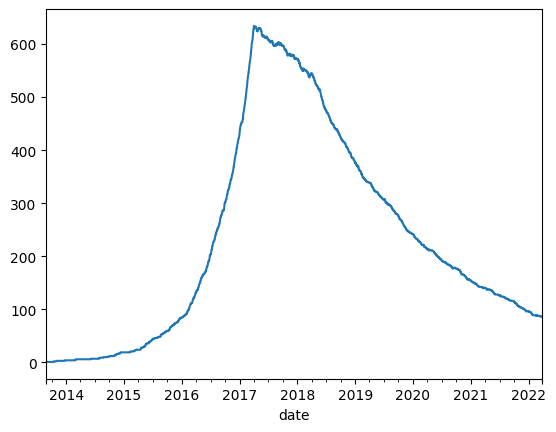

In [17]:
stock.sum(axis=1).plot()

## Flow

To look in more detail at the flow of the system we need to look at each episode combined with where the child goes afterwards. We can create a 'start_bin' and 'end_bin' looking at the placement type the child is in vs where they end up. We include the age at the start of the episode for both bins as we want to deal with 'ageing' separately.

**NOTE:** I believe it would be more accurate to deal with the age at the end of the episode as the additional ageing calculations will take children from the age of the previous placement and age them into the 'end' bin before they transition again. However, we want to retain the current functionality.

In [18]:
transitions = dc.enriched_view.copy()
transitions["start_bin"] = transitions.apply(
    lambda c: (c.age_bin.name, c.placement_type.name), axis=1
)
transitions["end_bin"] = transitions.apply(
    lambda c: (c.age_bin.name, c.placement_type_after.name), axis=1
)
transitions[['CHILD', 'DEC', 'start_bin', 'end_bin']]

,CHILD,DEC,start_bin,end_bin
69,91,2017-10-13,"(SIXTEEN_TO_EIGHTEEN, SUPPORTED)","(SIXTEEN_TO_EIGHTEEN, NOT_IN_CARE)"
358,290,2018-10-01,"(SIXTEEN_TO_EIGHTEEN, FOSTERING)","(SIXTEEN_TO_EIGHTEEN, FOSTERING)"
359,290,2018-11-08,"(SIXTEEN_TO_EIGHTEEN, FOSTERING)","(SIXTEEN_TO_EIGHTEEN, NOT_IN_CARE)"
507,519,2017-09-14,"(TEN_TO_SIXTEEN, FOSTERING)","(TEN_TO_SIXTEEN, FOSTERING)"
508,519,2018-02-19,"(TEN_TO_SIXTEEN, FOSTERING)","(TEN_TO_SIXTEEN, FOSTERING)"
...,...,...,...,...
820,994520,2017-12-12,"(TEN_TO_SIXTEEN, FOSTERING)","(TEN_TO_SIXTEEN, NOT_IN_CARE)"
74,994928,2020-06-17,"(TEN_TO_SIXTEEN, OTHER)","(TEN_TO_SIXTEEN, FOSTERING)"
55,994928,2021-11-25,"(TEN_TO_SIXTEEN, FOSTERING)","(TEN_TO_SIXTEEN, RESIDENTIAL)"
56,994928,NaT,"(SIXTEEN_TO_EIGHTEEN, RESIDENTIAL)","(SIXTEEN_TO_EIGHTEEN, NOT_IN_CARE)"


Each of the rows above represent a transfer from 'start_bin' to 'end_bin'. We can use the same approach as for the stock to group and count the transitions for each date. 

In [19]:
transition_count = transitions.groupby(["start_bin", "end_bin", "DEC"]).size()
transition_count

start_bin                      end_bin                        DEC       
(FIVE_TO_TEN, FOSTERING)       (FIVE_TO_TEN, FOSTERING)       2016-08-22    1
                                                              2016-12-07    1
                                                              2017-04-04    1
                                                              2017-04-05    1
                                                              2017-04-15    1
                                                                           ..
(TEN_TO_SIXTEEN, RESIDENTIAL)  (TEN_TO_SIXTEEN, SUPPORTED)    2020-08-16    1
                                                              2021-03-21    1
                                                              2022-02-15    1
(TEN_TO_SIXTEEN, SUPPORTED)    (TEN_TO_SIXTEEN, FOSTERING)    2019-12-13    1
                               (TEN_TO_SIXTEEN, NOT_IN_CARE)  2017-12-15    1
Length: 2431, dtype: int64

In [20]:
transitions_by_day = (
    transition_count.unstack(level=["start_bin", "end_bin"])
    .fillna(0)
    .asfreq("D", fill_value=0)
    .astype(int)
)

# Pick some random rows, but make sure they have some data
transitions_by_day[transitions_by_day.sum(axis=1)>5].sample(5)

start_bin  (FIVE_TO_TEN, FOSTERING)                             \
end_bin    (FIVE_TO_TEN, FOSTERING) (FIVE_TO_TEN, NOT_IN_CARE)   
DEC                                                              
2018-06-01                        1                          0   
2017-10-18                        2                          0   
2018-04-09                        0                          0   
2018-01-30                        1                          0   
2018-01-12                        3                          0   

start_bin                                                   \
end_bin    (FIVE_TO_TEN, OTHER) (FIVE_TO_TEN, RESIDENTIAL)   
DEC                                                          
2018-06-01                    0                          0   
2017-10-18                    0                          0   
2018-04-09                    0                          0   
2018-01-30                    0                          0   
2018-01-12                    0                          0   

start_bin      (FIVE_TO_TEN, OTHER)                             \
end_bin    (FIVE_TO_TEN, FOSTERING) (FIVE_TO_TEN, NOT_IN_CARE)   
DEC                                                              
2018-06-01                        0                          0   
2017-10-18                        0                          0   
2018-04-09                        0                          0   
2018-01-30                        0                          0   
2018-01-12                        1                          0   

start_bin                                                   \
end_bin    (FIVE_TO_TEN, OTHER) (FIVE_TO_TEN, RESIDENTIAL)   
DEC                                                          
2018-06-01                    0                          0   
2017-10-18                    0                          0   
2018-04-09                    0                          0   
2018-01-30                    0                          0   
2018-01-12                    0                          0   

start_bin  (FIVE_TO_TEN, RESIDENTIAL)                             ...  \
end_bin      (FIVE_TO_TEN, FOSTERING) (FIVE_TO_TEN, NOT_IN_CARE)  ...   
DEC                                                               ...   
2018-06-01                          0                          0  ...   
2017-10-18                          0                          0  ...   
2018-04-09                          0                          0  ...   
2018-01-30                          0                          0  ...   
2018-01-12                          0                          0  ...   

start_bin  (TEN_TO_SIXTEEN, OTHER)                                \
end_bin    (TEN_TO_SIXTEEN, OTHER) (TEN_TO_SIXTEEN, RESIDENTIAL)   
DEC                                                                
2018-06-01                       0                             0   
2017-10-18                       0                             0   
2018-04-09                       0                             0   
2018-01-30                       0                             0   
2018-01-12                       0                             0   

start_bin                              (TEN_TO_SIXTEEN, RESIDENTIAL)  \
end_bin    (TEN_TO_SIXTEEN, SUPPORTED)   (TEN_TO_SIXTEEN, FOSTERING)   
DEC                                                                    
2018-06-01                           0                             0   
2017-10-18                           0                             0   
2018-04-09                           0                             0   
2018-01-30                           0                             0   
2018-01-12                           0                             0   

start_bin                                                         \
end_bin    (TEN_TO_SIXTEEN, NOT_IN_CARE) (TEN_TO_SIXTEEN, OTHER)   
DEC                                                                
2018-06-01                           

We can quickly explore how many transitions we have

In [21]:
transitions_by_day.sum()

start_bin                           end_bin                           
(FIVE_TO_TEN, FOSTERING)            (FIVE_TO_TEN, FOSTERING)              305
                                    (FIVE_TO_TEN, NOT_IN_CARE)             88
                                    (FIVE_TO_TEN, OTHER)                   23
                                    (FIVE_TO_TEN, RESIDENTIAL)             39
(FIVE_TO_TEN, OTHER)                (FIVE_TO_TEN, FOSTERING)               19
                                    (FIVE_TO_TEN, NOT_IN_CARE)             14
                                    (FIVE_TO_TEN, OTHER)                   19
                                    (FIVE_TO_TEN, RESIDENTIAL)              2
(FIVE_TO_TEN, RESIDENTIAL)          (FIVE_TO_TEN, FOSTERING)               33
                                    (FIVE_TO_TEN, NOT_IN_CARE)             13
                                    (FIVE_TO_TEN, OTHER)                    4
                                    (FIVE_TO_TEN, RESIDENTIAL)         

So these represent raw transitions, but we're actually interested in the transition rates. What is the daily probabiliy of a transfer from one group to another?

## Rates

It makes no sense to look at the parts of the data where we only have incomplete numbers, so we're only going to consider stock and flow within the calendar year 2019.

Within the data, the probability per child is simply the number transfering out of a category divided by the number in that category. These will vary a lot from day to day though, so to get an estimate of the daily probably we take the mean value for this ratio. 

In [22]:
start_date, end_date = pd.to_datetime(['2019-01-01', '2019-12-31'])
stats = PopulationStats(dc.enriched_view, config)

stock = stats.stock.truncate(before=start_date, after=end_date)
stock.columns.name = "start_bin"
transitions = stats.transitions.truncate(before=start_date, after=end_date)

# Calculate the transition rates by aligning the two dataframes
stock, transitions = stock.align(transitions)

# Create the ratio of children moving vs those who were in that bin the day before
transition_rates = transitions / stock.shift(1).fillna(method="bfill")
transition_rates = transition_rates.fillna(0)
transition_rates.mean()

start_bin                           end_bin                           
(FIVE_TO_TEN, FOSTERING)            (FIVE_TO_TEN, FOSTERING)              0.002673
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.000865
                                    (FIVE_TO_TEN, OTHER)                  0.000208
                                    (FIVE_TO_TEN, RESIDENTIAL)            0.000400
(FIVE_TO_TEN, OTHER)                (FIVE_TO_TEN, FOSTERING)              0.003425
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.000000
                                    (FIVE_TO_TEN, OTHER)                  0.003288
                                    (FIVE_TO_TEN, RESIDENTIAL)            0.000391
(FIVE_TO_TEN, RESIDENTIAL)          (FIVE_TO_TEN, FOSTERING)              0.001533
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.001575
                                    (FIVE_TO_TEN, OTHER)                  0.000000
                

In this table we can see there are a fair few 'internal' transfers - these are children starting a different episode in the same placement category (could be a change of legal status, or a change of placement type to one within the same category). We don't really care about these numbers, so we could set these to zero if we wanted to as they don't affect the overall distribution.

## Entrants

Finally, there is another key number which is how many new children enter the system each day. 

In [23]:
stats.daily_entrants(start_date, end_date)

from  to                              
()    (FIVE_TO_TEN, FOSTERING)            0.005495
      (SIXTEEN_TO_EIGHTEEN, SUPPORTED)    0.002747
      (TEN_TO_SIXTEEN, FOSTERING)         0.024725
      (TEN_TO_SIXTEEN, RESIDENTIAL)       0.005495
Name: daily_entry_probability, dtype: float64

We get this view by looking at episodes starting in the analysis period and did not have an immediately preceeding episode.


In [24]:
df = stats.df
df = df[(df["DECOM"] >= start_date) & (df["DECOM"] <= end_date)]
df = df[df["placement_type_before"] == config.PlacementCategories.NOT_IN_CARE]
df[['CHILD', 'DECOM', 'age_bin', 'placement_type_before', 'placement_type']]

,CHILD,DECOM,age_bin,placement_type_before,placement_type
418,119095,2019-07-22,10 to 16,Not in care,Fostering
1,185992,2019-07-05,5 to 10,Not in care,Fostering
409,262711,2019-07-08,10 to 16,Not in care,Fostering
118,318887,2019-03-05,16 to 18+,Not in care,Supported
780,384546,2019-01-17,10 to 16,Not in care,Fostering
309,401650,2019-05-02,10 to 16,Not in care,Fostering
296,418846,2019-01-13,5 to 10,Not in care,Fostering
264,433741,2019-02-11,10 to 16,Not in care,Fostering
517,476742,2019-01-03,10 to 16,Not in care,Fostering
94,479556,2019-09-28,10 to 16,Not in care,Fostering


We group these by state and count

In [25]:
entrants = df.groupby(["age_bin", "placement_type"]).size()
entrants.name = "entrants"
entrants

age_bin    placement_type
5 to 10    Fostering         2
10 to 16   Fostering         9
           Residential       2
16 to 18+  Supported         1
Name: entrants, dtype: int64

Based on the period of analysis (the start and end dates) we calculate the probability per day

In [26]:
entrant_probability = entrants.reset_index()
entrant_probability["period_duration"] = (end_date - start_date).days
entrant_probability["daily_entry_probability"] = entrant_probability["entrants"] / entrant_probability["period_duration"]
entrant_probability = entrant_probability.set_index(["age_bin", "placement_type"])
entrant_probability

entrants  period_duration  daily_entry_probability
age_bin   placement_type                                                    
5 to 10   Fostering              2              364                 0.005495
10 to 16  Fostering              9              364                 0.024725
          Residential            2              364                 0.005495
16 to 18+ Supported              1              364                 0.002747

Note that the probabilities for new entrants are NOT based on the population in any prior bin, and thus needs to be treated differently than the others. 

# Ageing

There is one final probability, and that is simply what is the probability of a child moving to an 'older' age bin but within the same placement category. This one is simple as it only depends on the length of the bin which we can get from the configuration. 

In [27]:
ageing_out = []
for age_group in config.AgeBrackets:
    for pt in config.PlacementCategories:
        next_name = (age_group.next.name, pt.name) if age_group.next else tuple()
        ageing_out.append(
            {
                "from": (age_group.name, pt.name),
                "to": next_name,
                "rate": age_group.daily_probability,
            }
        )

ageing_out = pd.DataFrame(ageing_out)
ageing_out.set_index(["from", "to"], inplace=True)
ageing_out

,,rate
from,to,
"(BIRTH_TO_ONE, FOSTERING)","(ONE_TO_FIVE, FOSTERING)",0.002740
"(BIRTH_TO_ONE, RESIDENTIAL)","(ONE_TO_FIVE, RESIDENTIAL)",0.002740
"(BIRTH_TO_ONE, SUPPORTED)","(ONE_TO_FIVE, SUPPORTED)",0.002740
"(BIRTH_TO_ONE, OTHER)","(ONE_TO_FIVE, OTHER)",0.002740
"(BIRTH_TO_ONE, NOT_IN_CARE)","(ONE_TO_FIVE, NOT_IN_CARE)",0.002740
"(ONE_TO_FIVE, FOSTERING)","(FIVE_TO_TEN, FOSTERING)",0.000685
"(ONE_TO_FIVE, RESIDENTIAL)","(FIVE_TO_TEN, RESIDENTIAL)",0.000685
"(ONE_TO_FIVE, SUPPORTED)","(FIVE_TO_TEN, SUPPORTED)",0.000685
"(ONE_TO_FIVE, OTHER)","(FIVE_TO_TEN, OTHER)",0.000685
